Step 1: 函式庫、環境設定與資料載入
資料從 GCS 載入成功。
Step 2: 資料清理與特徵工程
處理 NaN 後，刪除了 55255 筆數據

 清理後資料集大小: 340775 筆, 分類特徵值已統一, 準備進行特徵編碼...
Step 3: K-Fold, 設三折, 數據分割與縮放 [防止和檢測過擬合 (Overfitting)]

最終特徵數量 (模型輸入維度): 53
FINAL_FEATURE_COLS 列表已成功儲存到 GCS: gs://huangwisley_bucket/model_artifacts/wesley_lending_feature_cols.json

 Scaler (MinMaxScaler) 已成功儲存到 GCS: gs://huangwisley_bucket/model_artifacts/wesley_lending_scaler_xgb.pkl
 數據分割完成 (Train: 272619 / Validation: 34078 / Test: 34078)
Step 4 : 模型參數調校與交叉驗證 (Grid Search)
計算類別權重 (Scale Pos Weight): 0.25

 開始執行 GridSearchCV 搜索 8 種參數組合 (CV=3)...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END ...........gamma=0, learning_rate=0.05, max_depth=5; total time=   2.2s
[CV] END ...........gamma=0, learning_rate=0.05, max_depth=5; total time=   2.1s
[CV] END ...........gamma=0, learning_rate=0.05, max_depth=5; total time=   2.1s
[CV] END ...........gamma=0, learning_rate=0.05, max_depth=7; total time=   2.7s
[CV] END ...........gamma=0, learning_rate

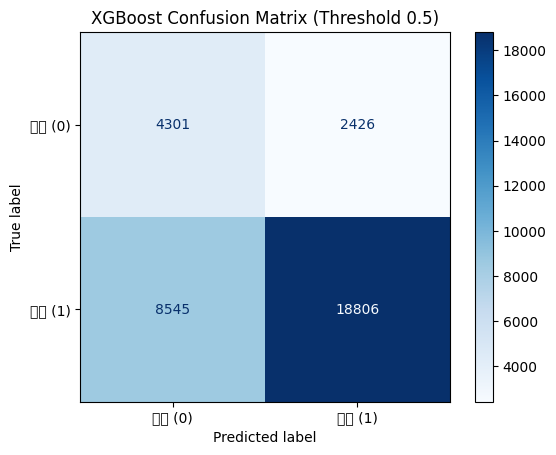


 模型評估完成。
# Step 7: SHAP 模型可解釋性、載入模型與測試新客戶資料 (Deployment Simulation)


=============== 部署模擬測試 (優先使用 JSON 載入) ================
成功載入最佳樹數量: 211
所有模型工件 (Scaler, Model, Feature Columns) 載入成功，準備測試新客戶數據。
執行 SHAP 數據完整性檢查與修復...
 X_test_scaled 數據清洗完成，所有欄位已強制轉換為 float32。
 已對測試集進行抽樣，僅使用 10,000 筆數據進行 SHAP 計算，輸入為 float32 NumPy 陣列。
 正在計算 SHAP 值 (通用 Explainer 可能需要較長時間)...


PermutationExplainer explainer: 10001it [15:52, 10.42it/s]                           


 正在使用通用 Explainer，基線值由背景數據集的平均 base_values 決定

** SHAP 基線值 (Base Value/平均還款機率): 0.5522**

=============== SHAP 模型解釋 (整體行為) ================

 Top 5 SHAP 特徵 (中英文名稱和數值) 已成功儲存到 GCS: gs://huangwisley_bucket/model_artifacts/wesley_lending_shap_summary.json
 已使用 SHAP 提取 Top 5 關鍵解釋特徵。

[1] SHAP 摘要圖 (Beeswarm Plot): 顯示特徵對預測的推動和拉低作用 (紅點推高、藍點拉低還款機率)


/tmp/ipython-input-1425306471.py:604: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_sample_df, max_display=15, show=False)


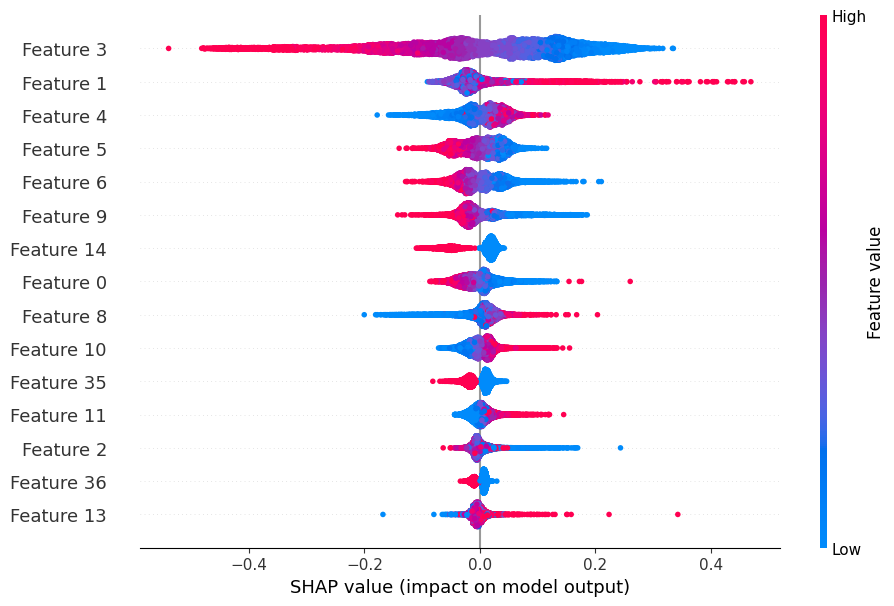


[2] SHAP 條形圖 (Bar Plot): 特徵重要性排名 (平均貢獻度)


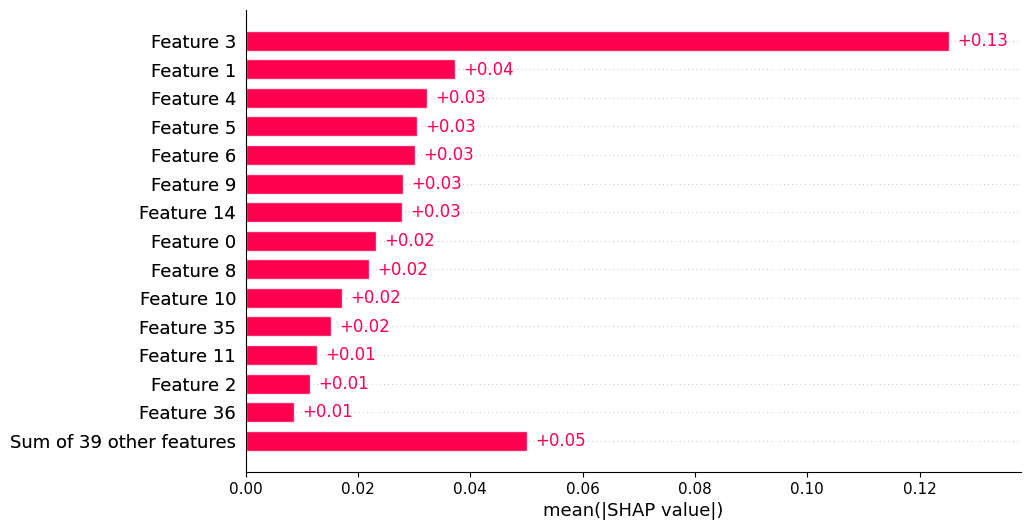



--- 3 筆新客戶的預測結果 (控制台輸出) ---
Predicted_Probability 是模型預測的還款機率 (值越高越可能還款)。
   loan_amnt  int_rate  annual_inc  Predicted_Probability  \
0    30000.0      18.5     45000.0               0.218804   
1    15000.0      12.0     75000.0               0.852686   
2     5000.0       6.5    120000.0               0.970880   

  Predicted_Loan_Repaid  
0             會違約 (高風險)  
1             會還款 (低風險)  
2             會還款 (低風險)  

 報告已成功儲存到 GCS: gs://huangwisley_bucket/wesley_lending_report_xgb.doc

 預測流程模擬完成。


In [1]:
# ===============
# 貸款違約預測模型
# ===============


# Step 1: 函式庫、環境設定與資料載入
print("Step 1: 函式庫、環境設定與資料載入")
# 函式庫載入
import pandas as pd              # 數據處理
import numpy as np               # 數值運算
import joblib                    # 核心工具：用於 Scaler/PKL 備用模型儲存
import fsspec                    # 檔案系統抽象層 (GCS 讀寫)
import json                      # 用於儲存特徵列表及 SHAP 結果
import xgboost as xgb            # 核心模型：XGBoost
import matplotlib.pyplot as plt  # 繪圖
import os                        # 用於檔案操作 (處理臨時 JSON 檔案)
import shap                      # 模型可解釋性 (SHAP)
import time                      # 用於計算調優時間

# Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold # 資料分割、網格搜索與交叉驗證
from sklearn.preprocessing import MinMaxScaler, LabelEncoder # 特徵縮放與編碼
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score # 模型評估

# 設置中文字體 (解決 Matplotlib 警告)
# 由於執行環境可能缺乏中文字體, 僅在輸出報告時使用中文，圖表保持英文或避免中文標籤
# 忽略 Matplotlib 的中文字體警告, 主要關注邏輯正確性
import warnings
warnings.filterwarnings("ignore", "Glyph.*missing from font")

# GCS 雲端儲存路徑設定
GCS_BUCKET_NAME = 'huangwisley_bucket'
GCS_DATA_PATH = f'gs://{GCS_BUCKET_NAME}/wesley_lending_data.csv'
GCS_SCALER_PATH = f'gs://{GCS_BUCKET_NAME}/model_artifacts/wesley_lending_scaler_xgb.pkl'

# 模型路徑
GCS_MODEL_PATH_JSON = f'gs://{GCS_BUCKET_NAME}/model_artifacts/wesley_lending_model_xgb.json'
GCS_MODEL_PATH_PKL = f'gs://{GCS_BUCKET_NAME}/model_artifacts/wesley_lending_model_xgb.pkl'

# 其他工件路徑
GCS_FEATURE_COLS_PATH = f'gs://{GCS_BUCKET_NAME}/model_artifacts/wesley_lending_feature_cols.json' # 儲存 FINAL_FEATURE_COLS 清單
GCS_SHAP_SUMMARY_PATH = f'gs://{GCS_BUCKET_NAME}/model_artifacts/wesley_lending_shap_summary.json' # 儲存 Top SHAP 結果

# 測試資料集
GCS_TEST_DATA_PATH = f'gs://{GCS_BUCKET_NAME}/test_data/test_customers.csv'

# 最佳樹數量
GCS_BEST_ESTIMATORS_PATH = f'gs://{GCS_BUCKET_NAME}/model_artifacts/wesley_lending_best_estimators.json'

# 結果報告
GCS_REPORT_PATH = f'gs://{GCS_BUCKET_NAME}/wesley_lending_report_xgb.doc'


# 資料載入
try:
    df = pd.read_csv(GCS_DATA_PATH)
    print("資料從 GCS 載入成功。")
except Exception as e:
    print(f"資料載入失敗，請檢查 GCS 路徑或權限: {e}")
    df = pd.DataFrame()


# Step 2: 資料清理與特徵工程
print("Step 2: 資料清理與特徵工程")
if df.empty:
    print("跳過Step 2")
else:
    # 1. 建立目標標籤 (Label)
    # [重要] Fully Paid: 1 (還款), Charged Off: 0 (違約)
    df['loan_repaid'] = df['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})
    df = df.drop('loan_status', axis=1)

    # 2. 刪除無用/高獨特值欄位
    columns_to_drop = [
        'issue_d', 'emp_title', 'title', 'address', 'zip_code', 'initial_list_status'
    ]
    df = df.drop(columns_to_drop, axis=1, errors='ignore')

    # 3. 處理遺失值 (Missing Values)
    initial_rows = len(df)
    df = df.dropna()
    print(f"處理 NaN 後，刪除了 {initial_rows - len(df)} 筆數據")

    # 4. 處理日期欄位 (earliest_cr_line)
    # 提取年份作為新特徵
    df['earliest_cr_line_year'] = df['earliest_cr_line'].apply(lambda date: int(date[-4:]))
    df = df.drop('earliest_cr_line', axis=1)

    # 5. 對所有分類欄位的值進行清理 (移除空格和特殊字符)
    for col in df.select_dtypes(include=['object']).columns:
        if col not in ['loan_status', 'earliest_cr_line']: # 已被處理或移除
            df[col] = df[col].astype(str).str.strip().str.replace(' ', '_').str.replace('+', '_plus').str.replace('<', 'less_than').str.replace('[', '').str.replace(']', '')
            # 確保與訓練集一致的映射
            if col == 'emp_length':
                df[col] = df[col].str.replace('10_plus_years', '10_plus_years')
                df[col] = df[col].str.replace('less_than_1_year', '0_years')

    print(f"\n 清理後資料集大小: {len(df)} 筆, 分類特徵值已統一, 準備進行特徵編碼...")


# Step 3: K-Fold, 設三折, 數據分割與縮放 [防止和檢測過擬合 (Overfitting)]
print("Step 3: K-Fold, 設三折, 數據分割與縮放 [防止和檢測過擬合 (Overfitting)]")
if df.empty:
    print("跳過Step 3")
else:
    # 1. 分離特徵 (X_all) 與標籤 (y_all)
    X_all = df.drop('loan_repaid', axis=1)
    y_all = df['loan_repaid']

    # 2. Label Encoding (針對有序類別：sub_grade)
    le = LabelEncoder()
    subgrade_map = sorted(df['sub_grade'].unique()) # 取得所有唯一的 sub_grade (自動排序，A1最小，G5最大)
    le.fit(subgrade_map)
    X_all['sub_grade'] = le.transform(X_all['sub_grade'])

    # 3. One-Hot Encoding (針對無序類別)
    categorical_cols = X_all.select_dtypes(include=['object']).columns
    X_encoded_all = pd.get_dummies(X_all, columns=categorical_cols, drop_first=True)

    X_all = X_encoded_all # 使用 One-Hot Encoding 後的數據作為新的 X_all

    # 4. 取得最終特徵列表與維度
    FINAL_FEATURE_COLS = X_all.columns.tolist()
    input_dim = X_all.shape[1]
    print(f"\n最終特徵數量 (模型輸入維度): {input_dim}")

    # 儲存 FINAL_FEATURE_COLS 列表到 GCS
    try:
        with fsspec.open(GCS_FEATURE_COLS_PATH, "w") as f:
            json.dump(FINAL_FEATURE_COLS, f)
        print(f"FINAL_FEATURE_COLS 列表已成功儲存到 GCS: {GCS_FEATURE_COLS_PATH}")
    except Exception as e:
        print(f"錯誤: 無法儲存特徵列表到 GCS: {e}")

    # =========================================================
    # 5. 三折數據分割 (Train: 80%, Validation: 10%, Test: 10%)
    # =========================================================

    # 第一次切割：分離出最終的測試集 (Test Set) - 佔總體的 10%
    X_temp, X_test, y_temp, y_test = train_test_split(
        X_all, y_all, test_size=0.1, random_state=101, stratify=y_all
    )

    # 第二次切割：將剩餘的數據分割為訓練集 (Train Set) 和驗證集 (Validation Set)
    # 驗證集 (X_val) 佔 X_temp (90%) 的比例：0.1 / 0.9 ≈ 0.1111
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=(0.1 / 0.9), random_state=101, stratify=y_temp
    )

    # 6. 特徵縮放 (Scaling)
    scaler = MinMaxScaler()

    # 對 X_train 進行 fit_transform，對 X_val 和 X_test 進行 transform
    X_train_scaled_array = scaler.fit_transform(X_train)
    X_val_scaled_array = scaler.transform(X_val)
    X_test_scaled_array = scaler.transform(X_test)

    # 轉換回 DataFrame 形式 (保留列名用於 SHAP 繪圖)
    X_train_scaled = pd.DataFrame(X_train_scaled_array, columns=FINAL_FEATURE_COLS)
    X_val_scaled = pd.DataFrame(X_val_scaled_array, columns=FINAL_FEATURE_COLS)
    X_test_scaled = pd.DataFrame(X_test_scaled_array, columns=FINAL_FEATURE_COLS)

    # 7. 儲存訓練好的 Scaler (用於部署 API)
    with fsspec.open(GCS_SCALER_PATH, "wb") as f:
        joblib.dump(scaler, f)

    print(f"\n Scaler (MinMaxScaler) 已成功儲存到 GCS: {GCS_SCALER_PATH}")
    print(f" 數據分割完成 (Train: {len(X_train)} / Validation: {len(X_val)} / Test: {len(X_test)})")


# Step 4 : 模型參數調校與交叉驗證 (Grid Search)
print("Step 4 : 模型參數調校與交叉驗證 (Grid Search)")

if 'X_train_scaled' not in locals():
    print("跳過 Step 4")
else:
    # 1. 重新計算類別權重
    neg_count = y_train.value_counts()[0]
    pos_count = y_train.value_counts()[1]
    scale_pos_weight_value = neg_count / pos_count
    print(f"計算類別權重 (Scale Pos Weight): {scale_pos_weight_value:.2f}")


    # 2. 初始化基礎模型 (用於 CV)
    xgb_base = xgb.XGBClassifier(
        objective='binary:logistic',
        n_estimators=100,
        scale_pos_weight=scale_pos_weight_value,
        eval_metric='logloss',
        random_state=101,
        n_jobs=-1
    )

    # 3. 設定要搜索的參數空間
    param_grid = {
        'max_depth': [5, 7],
        'learning_rate': [0.05, 0.1],
        'gamma': [0, 0.2]
    }

    # 4. 定義交叉驗證策略 (Stratified K-Fold)
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=101)

    # 5. 初始化 GridSearchCV (優化目標在於 最大化 ROC AUC)
    grid_search = GridSearchCV(
        estimator=xgb_base,
        param_grid=param_grid,
        scoring='roc_auc',
        cv=skf,
        verbose=2
    )

    # 6. 開始執行網格搜索 (使用訓練集 X_train_scaled)
    start_time = time.time()
    num_combinations = len(param_grid['max_depth']) * len(param_grid['learning_rate']) * len(param_grid['gamma'])
    print(f"\n 開始執行 GridSearchCV 搜索 {num_combinations} 種參數組合 (CV={skf.n_splits})...")
    grid_search.fit(X_train_scaled, y_train)
    end_time = time.time()
    print(f"\n GridSearchCV 執行完成，總耗時: {end_time - start_time:.2f} 秒。")

    # 7. 輸出最佳結果並儲存
    BEST_PARAMS = grid_search.best_params_
    BEST_SCORE = grid_search.best_score_
    print("=========================================================")
    print(f"** 最佳 AUC 分數 (交叉驗證): {BEST_SCORE:.4f}**")
    print(f"**️ 最佳參數組合 (BEST_PARAMS): {BEST_PARAMS}**")
    print("=========================================================")

    # 8. 檢查並設定參數
    print("最佳參數已儲存, 將在下一階段 (Step 5) 用於最終模型訓練")
    print("================================================================")


# Step 5 : 因為 XGBoost 3.1.1, 所以使用 xgb.train 實現 Early Stopping 與儲存
print("# Step5 : 因為 XGBoost 3.1.1, 所以使用 xgb.train 實現 Early Stopping 與儲存")

if 'X_train_scaled' not in locals():
    print("跳過Step 5")
else:
    # 1. 處理類別不平衡 (Scale Pos Weight)
    neg_count = y_train.value_counts()[0]
    pos_count = y_train.value_counts()[1]
    scale_pos_weight_value = neg_count / pos_count

    print(f"\n 計算類別權重 (Scale Pos Weight): {scale_pos_weight_value:.2f}")

    # =======================================================
    # 關鍵修正：將 Pandas DataFrame 轉換為 DMatrix 格式 (xgb.train 需要)
    # =======================================================
    D_train = xgb.DMatrix(X_train_scaled, label=y_train)
    D_val = xgb.DMatrix(X_val_scaled, label=y_val)

    # 2. 模型參數定義 (用於 xgb.train)
    if 'BEST_PARAMS' in locals():
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'scale_pos_weight': scale_pos_weight_value,
            'seed': 101,
            # 將 BEST_PARAMS 代入
            'max_depth': BEST_PARAMS.get('max_depth', 6),
            'learning_rate': BEST_PARAMS.get('learning_rate', 0.1),
            'gamma': BEST_PARAMS.get('gamma', 0)
        }
    else:
        # 使用預設參數
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'scale_pos_weight': scale_pos_weight_value,
            'seed': 101,
            'max_depth': 6,
            'learning_rate': 0.1,
            'gamma': 0
        }

    # 3. 訓練模型 (使用 xgb.train)
    watchlist = [(D_train, 'train'), (D_val, 'validation')]
    n_estimators_max = 3000
    early_stop_rounds = 50

    print("\n 開始 XGBoost 模型訓練 (使用 xgb.train 實現 AUC 早停)...")

    # 使用 xgb.train (這是 3.1.1 版本中唯一支持 Early Stopping 的 function)
    xgb_bst = xgb.train(
        params,
        D_train,
        num_boost_round=n_estimators_max,
        evals=watchlist,
        early_stopping_rounds=early_stop_rounds,
        verbose_eval=False
    )

    # 獲取最佳迭代次數 (Best n_estimators)
    best_n_estimators = xgb_bst.best_iteration + 1
    print(f" 早停啟動！模型在第 {best_n_estimators} 棵樹時達到最佳性能。")

    # 4. 儲存模型並兼容後續步驟 (創建一個 XGBClassifier 物件)
    LOCAL_MODEL_PATH_JSON = 'wesley_lending_model_xgb_temp.json'
    LOCAL_MODEL_PATH_PKL = 'wesley_lending_model_xgb_temp.pkl'

    # --- 儲存最佳樹數量 ---
    try:
        with fsspec.open(GCS_BEST_ESTIMATORS_PATH, "w") as f:
            json.dump({'best_n_estimators': best_n_estimators}, f)
        print(f"最佳樹數量 ({best_n_estimators}) 已儲存到 GCS: {GCS_BEST_ESTIMATORS_PATH}")
    except Exception as e:
        print(f"錯誤: 無法儲存最佳樹數量到 GCS: {e}")

    # --- 儲存 JSON (主部署格式) ---
    try:
        # 由於是 xgb.Booster 物件，使用 save_model 儲存
        xgb_bst.save_model(LOCAL_MODEL_PATH_JSON)

        # 上傳到 GCS
        with open(LOCAL_MODEL_PATH_JSON, 'rb') as f_in:
            with fsspec.open(GCS_MODEL_PATH_JSON, 'wb') as f_out:
                f_out.write(f_in.read())
        # os.remove(LOCAL_MODEL_PATH_JSON) # 暫不刪除，下一步使用
        print(f"\n XGBoost 模型 (JSON 格式) 已成功上傳到 GCS: {GCS_MODEL_PATH_JSON}")
    except Exception as e:
        print(f"\n 錯誤: 無法儲存或上傳 JSON 模型: {e}")


    # --- 為了兼容 後續步驟, 將 xgb.Booster 包裝回 XGBClassifier ---

    # 複製 params 並移除重複的鍵, 只保留超參數
    classifier_params = params.copy()
    keys_to_remove = ['objective', 'eval_metric', 'scale_pos_weight', 'seed']
    for key in keys_to_remove:
        classifier_params.pop(key, None)

    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic',
        n_estimators=best_n_estimators, # 設置為正確的最佳樹數量
        scale_pos_weight=scale_pos_weight_value,
        eval_metric='auc',
        random_state=101,
        n_jobs=-1,
        **classifier_params # 只傳遞 max_depth, learning_rate, gamma
    )

    # 載入剛剛儲存的權重到 XGBClassifier
    xgb_model.load_model(LOCAL_MODEL_PATH_JSON) # XGBoost 的 load_model() 只能是本地路徑
    os.remove(LOCAL_MODEL_PATH_JSON) # 清理本地檔案

    # --- 儲存 PKL (備用格式) --- (用 joblib 做 file i/o)
    try:
        joblib.dump(xgb_model, LOCAL_MODEL_PATH_PKL)
        # 上傳到 GCS
        with open(LOCAL_MODEL_PATH_PKL, 'rb') as f_in:
            with fsspec.open(GCS_MODEL_PATH_PKL, 'wb') as f_out:
                f_out.write(f_in.read())
        os.remove(LOCAL_MODEL_PATH_PKL)
        print(f" XGBoost 模型 (PKL 格式) 已成功儲存到 GCS: {GCS_MODEL_PATH_PKL}")
    except Exception as e:
        print(f" 錯誤: 無法儲存或上傳 PKL 模型: {e}")


# Step 6: 模型評估與預測 (Model Evaluation)
print("# Step 6: 模型評估與預測 (Model Evaluation)")

if 'xgb_model' not in locals():
    print("跳過 Step 6")
else:
    # 1. 預測與閾值設定 (Threshold)
    # 關鍵修正：直接使用 Step 5 確定的 best_n_estimators 變數，避免呼叫不兼容的 get_booster().best_ntree_limit
    if 'best_n_estimators' not in locals():
        # 如果 Step 5 失敗，嘗試使用 xgb_model.n_estimators (通常會被 load_model 設置)
        best_n_estimators = xgb_model.n_estimators

    probabilities = xgb_model.predict_proba(X_test_scaled, iteration_range=(0, best_n_estimators))[:, 1]

    # 使用優化後的決策閾值 0.50
    OPTIMAL_THRESHOLD = 0.50

    predictions = (probabilities >= OPTIMAL_THRESHOLD).astype(int)

    # 2. 輸出分類報告 (Classification Report)
    print("\n分類報告 (Classification Report):")
    print(classification_report(y_test, predictions))

    # 3. 輸出混淆矩陣 (Confusion Matrix)
    cm = confusion_matrix(y_test, predictions)

    print("="*60)
    print("          【混淆矩陣 (Confusion Matrix)】")
    print(f"            決策閾值: {OPTIMAL_THRESHOLD}")
    print("="*60)

    cm_df = pd.DataFrame(
        cm,
        index=['實際違約 (0): 違約者總數', '實際還款 (1): 還款者總數'],
        columns=['預測違約 (0): 拒絕放貸', '預測還款 (1): 決定放貸']
    )
    print(cm_df)

    # 額外註釋關鍵錯誤類型
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    print(f"\n[關鍵解析] 假陽性 (FP): {FP} => 銀行發貸給違約者 (直接現金損失)")
    print(f"[關鍵解析] 假陰性 (FN): {FN} => 銀行錯誤拒絕好客戶 (機會成本損失)")

    # 4. 輸出 ROC-AUC (作為模型精度的重要指標)
    auc_score = roc_auc_score(y_test, probabilities)
    print(f"\n 模型 AUC 分數 (測試集): {auc_score:.4f} (使用 {best_n_estimators} 棵樹)")

    # 5. 輸出混淆矩陣視覺化圖表
    try:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                         display_labels=['違約 (0)', '還款 (1)'])
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'XGBoost Confusion Matrix (Threshold {OPTIMAL_THRESHOLD})')
        plt.show()
    except Exception as e:
        print(f"無法顯示圖形輸出: {e}")

    print("\n 模型評估完成。")


# Step 7: SHAP 模型可解釋性、載入模型與測試新客戶資料 (Deployment Simulation)
print("# Step 7: SHAP 模型可解釋性、載入模型與測試新客戶資料 (Deployment Simulation)")

# 初始化 base_value
base_value = 0.0

print("\n\n=============== 部署模擬測試 (優先使用 JSON 載入) ================")

# 1. 載入必要的訓練產物, 有4個(Model, Scaler, Final Feature Columns, Best Estimators)

# --- 載入所有工件 ---
xgb_model_loaded = None
LOCAL_MODEL_PATH_JSON_TEMP = 'wesley_lending_model_xgb_temp_loaded.json'
best_n_estimators_loaded = 1000 # 預設值，以防載入失敗

try:
    # 載入最佳樹數量
    GCS_BEST_ESTIMATORS_PATH = f'gs://{GCS_BUCKET_NAME}/model_artifacts/wesley_lending_best_estimators.json'
    with fsspec.open(GCS_BEST_ESTIMATORS_PATH, "r") as f:
        best_n_estimators_loaded = json.load(f)['best_n_estimators']
    print(f"成功載入最佳樹數量: {best_n_estimators_loaded}")

    # 載入
    # A. Scaler
    with fsspec.open(GCS_SCALER_PATH, "rb") as f:
        scaler_loaded = joblib.load(f)

    # B. Model
    with fsspec.open(GCS_MODEL_PATH_JSON, 'rb') as f_in:
        with open(LOCAL_MODEL_PATH_JSON_TEMP, 'wb') as f_out:
            f_out.write(f_in.read())

    # C. Final Feature Columns (用於特徵對齊)
    with fsspec.open(GCS_FEATURE_COLS_PATH, "r") as f:
        FINAL_FEATURE_COLS_LOADED = json.load(f)

    # D. 重新建立 LabelEncoder 的 classes 列表
    le_loaded = LabelEncoder()
    if 'le' in locals():
          le_loaded.classes_ = le.classes_
    else:
        print("警告: 訓練階段的 LabelEncoder 遺失。手動初始化 sub_grade classes。")
        all_subgrades = [f'{grade}{num}' for grade in 'ABCDEFG' for num in range(1, 6)]
        le_loaded.classes_ = np.array(all_subgrades)

    # E. Best Estimators
    xgb_model_loaded = xgb.XGBClassifier(n_estimators=best_n_estimators_loaded, random_state=101)
    xgb_model_loaded.load_model(LOCAL_MODEL_PATH_JSON_TEMP)

    # 清理本地臨時檔案
    os.remove(LOCAL_MODEL_PATH_JSON_TEMP)


    print("所有模型工件 (Scaler, Model, Feature Columns) 載入成功，準備測試新客戶數據。")
except Exception as e:
    print(f"\n 錯誤：載入模型工件失敗。請檢查 GCS 路徑或檔案: {e}")
    if 'xgb_model_loaded' not in locals() or xgb_model_loaded is None:
        xgb_model_loaded = None
        FINAL_FEATURE_COLS_LOADED = None
        print(" 警告: 跳過後續預測步驟。")


# -------------------------------------------------------------
# 🆕 特徵解釋對照表 (Feature Glossary)
# -------------------------------------------------------------
FEATURE_GLOSSARY = {
    'loan_amnt': '貸款金額', 'term': '貸款期限 (月)', 'int_rate': '貸款利率',
    'installment': '月付款', 'sub_grade': '次級信用評級 (數值化)', 'emp_length': '工作年限 (年)',
    'annual_inc': '年收入', 'dti': '債務收入比', 'open_acc': '開放信用額度數',
    'pub_rec': '公共紀錄數', 'revol_bal': '循環信貸餘額', 'revol_util': '循環信貸使用率',
    'total_acc': '總信用帳戶數量', 'mort_acc': '房貸帳戶數', 'pub_rec_bankruptcies': '公共破產紀錄數',
    'earliest_cr_line_year': '最早信用紀錄年份',
}
# -------------------------------------------------------------


# --- 輔助解釋模型函式 (使用載入的特徵列表) ---
if xgb_model_loaded and FINAL_FEATURE_COLS_LOADED and 'X_test_scaled' in locals():

    # 數據清洗：確保 X_test_scaled 中沒有字串
    print("執行 SHAP 數據完整性檢查與修復...")
    try:
        # 1. 將所有欄位強制轉換為數值類型
        for col in X_test_scaled.columns:
            X_test_scaled[col] = pd.to_numeric(X_test_scaled[col], errors='coerce')

        # 2. 處理可能產生的 NaN 值 (用 0 填充)
        X_test_scaled = X_test_scaled.fillna(0.0)

        # 3. 確保整個 DataFrame 最終是 float32
        X_test_scaled = X_test_scaled.astype(np.float32)

        print(" X_test_scaled 數據清洗完成，所有欄位已強制轉換為 float32。")
    except Exception as e:
        print(f" 數據清洗過程中發生錯誤: {e}")
        pass


    try:
        # =======================================================
        # SHAP 模型解釋 (使用通用 Explainer)
        # =======================================================

        # 🆕 優化步驟 1: 僅取 10,000 個樣本進行 SHAP 計算
        SAMPLE_SIZE = 10000
        sample_size_actual = min(SAMPLE_SIZE, len(X_test_scaled))

        # 採樣 DataFrame (用於繪圖的列名)
        X_test_sample_df = X_test_scaled.sample(n=sample_size_actual, random_state=101)

        # SHAP 必須使用純 NumPy 陣列
        X_test_sample_np = X_test_sample_df.values

        print(f" 已對測試集進行抽樣，僅使用 {sample_size_actual:,} 筆數據進行 SHAP 計算，輸入為 float32 NumPy 陣列。")

        # 2. SHAP 初始化與計算 (通用方法)

        # 定義模型預測的 callable 函數 (只返回類別 1 的機率)
        model_predict_proba_func = lambda X: xgb_model_loaded.predict_proba(X, iteration_range=(0, best_n_estimators_loaded))[:, 1]

        # 使用通用的 shap.Explainer
        explainer = shap.Explainer(model_predict_proba_func, X_test_sample_np)

        # 3. 計算 SHAP 值
        print(" 正在計算 SHAP 值 (通用 Explainer 可能需要較長時間)...")
        # shap_values 已經是一個 shap.Explanation 物件
        shap_values = explainer(X_test_sample_np)


        # 從返回的 Explanation 物件中獲取 base_values
        if hasattr(shap_values, 'base_values') and shap_values.base_values is not None:
             # 計算 base_value 的平均值作為報告輸出
             base_value = np.mean(shap_values.base_values)
             print(" 正在使用通用 Explainer，基線值由背景數據集的平均 base_values 決定")
        else:
             # Fallback: 如果 base_values 不存在 (極少數情況), 使用模型對背景數據的平均預測
             base_value = np.mean(model_predict_proba_func(X_test_sample_np))
             print("️ 警告: 無法從 Explanation 物件中獲取 base_values, 使用模型對背景數據的平均預測作為基線")


        print(f"\n=======================================================")
        print(f"** SHAP 基線值 (Base Value/平均還款機率): {base_value:.4f}**")
        print(f"=======================================================")

        print("\n=============== SHAP 模型解釋 (整體行為) ================")

        # C. 提取基於 SHAP 的 TOP N 特徵列表並輸出到 GCS (使用 Explanation 物件的 .values)
        TOP_N = 5
        shap_importances = pd.Series(np.abs(shap_values.values).mean(axis=0), index=FINAL_FEATURE_COLS_LOADED)
        top_shap_df = shap_importances.sort_values(ascending=False).head(TOP_N).reset_index()
        top_shap_df.columns = ['Feature_EN', 'Mean_Absolute_SHAP_Value']

        def get_chinese_name(feature_en):
            base_feature = feature_en.split('_')[0]
            if feature_en.startswith('term_'):
                return f"{FEATURE_GLOSSARY.get('term', '貸款期限')} ({feature_en.replace('term_', '')} 個月)"
            elif feature_en.startswith('home_ownership_'):
                return f"{FEATURE_GLOSSARY.get('home_ownership', '居住狀態')} ({feature_en.replace('home_ownership_', '')})"
            elif feature_en.startswith('emp_length_'):
                return f"{FEATURE_GLOSSARY.get('emp_length', '工作年限')} ({feature_en.replace('emp_length_', '')})"
            else:
                return FEATURE_GLOSSARY.get(feature_en, feature_en)

        top_shap_df['Feature_CN'] = top_shap_df['Feature_EN'].apply(get_chinese_name)

        # 儲存前五名 SHAP 結果到 GCS (JSON 格式)
        top_shap_output = top_shap_df.to_dict('records')

        try:
            with fsspec.open(GCS_SHAP_SUMMARY_PATH, "w", encoding='utf-8') as f:
                json.dump(top_shap_output, f, ensure_ascii=False, indent=4)
            print(f"\n Top {TOP_N} SHAP 特徵 (中英文名稱和數值) 已成功儲存到 GCS: {GCS_SHAP_SUMMARY_PATH}")
        except Exception as e:
            print(f"\n 錯誤: 無法儲存 SHAP 摘要結果到 GCS: {e}")

        TOP_FEATURES = top_shap_df['Feature_EN'].tolist() # 更新 TOP_FEATURES 列表
        print(f" 已使用 SHAP 提取 Top {TOP_N} 關鍵解釋特徵。")

        # A. SHAP 摘要圖 (Beeswarm Plot)
        print("\n[1] SHAP 摘要圖 (Beeswarm Plot): 顯示特徵對預測的推動和拉低作用 (紅點推高、藍點拉低還款機率)")
        # 直接傳入 shap_values Explanation 物件和 DataFrame
        shap.summary_plot(shap_values, X_test_sample_df, max_display=15, show=False)
        plt.gcf().set_size_inches(10, 6)
        plt.show()

        # B. SHAP 條形圖 (Bar Plot)
        print("\n[2] SHAP 條形圖 (Bar Plot): 特徵重要性排名 (平均貢獻度)")
        shap.plots.bar(shap_values.abs.mean(0), max_display=15, show=False)
        plt.gcf().set_size_inches(10, 6)
        plt.show()
        print("=======================================================\n")

        # --- 解釋函數定義 ---
        def generate_explanation(probability, customer_data, encoded_data_row):
            """根據機率和頂級特徵數值, 產生一個簡單的預測解釋"""
            result = '會還款 (低風險)' if probability >= OPTIMAL_THRESHOLD else '會違約 (高風險)'
            base_reason = f"客戶的財務特徵整體表現優異，還款機率高於 {OPTIMAL_THRESHOLD * 100}% 的門檻。" if probability >= OPTIMAL_THRESHOLD else f"客戶的財務特徵表現出潛在的信用風險，還款機率未達 {OPTIMAL_THRESHOLD * 100}% 的門檻。"

            details = []

            for feature in TOP_FEATURES:
                display_name = FEATURE_GLOSSARY.get(feature.split('_')[0] if feature.startswith('term_') or feature.startswith('verification_status_') else feature, feature)

                value = None
                if feature in encoded_data_row:
                    value = encoded_data_row[feature]
                else:
                    continue

                if not isinstance(value, str) and pd.notna(value):
                    if feature in ['annual_inc', 'dti', 'revol_util', 'loan_amnt', 'int_rate', 'earliest_cr_line_year']:
                        context_comment = "該縮放值對模型預測的貢獻度大，請參考 SHAP 圖表判斷具體影響方向。"
                        details.append(f"- {feature} ({display_name}) (縮放值: {value:,.4f}) -> 判斷依據: {context_comment}")
                    elif feature == 'sub_grade':
                        details.append(f"- {feature} (次級評級) (縮放值: {value:,.4f}) -> 判斷依據: 數值越低（接近 0），信用越好。")
                elif feature.startswith('home_ownership_') and value == 1:
                    category = feature.replace('home_ownership_', '')
                    details.append(f"- {feature} (居住狀態) -> 判斷依據: 客戶狀態為 {category}，影響模型判斷。")
                elif feature.startswith('emp_length_') and value == 1:
                    category = feature.replace('emp_length_', '')
                    details.append(f"- {feature} (工作年限) -> 判斷依據: 客戶工作年限為 {category}，影響模型判斷。")
                elif feature.startswith('term_') and value == 1:
                    category = feature.replace('term_', '')
                    details.append(f"- {feature} (貸款期限) -> 判斷依據: 客戶貸款期限為 {category} 月，影響模型判斷。")

            if not details:
                details.append("- (Top 特徵縮放值皆為 0 或無意義，請檢查模型輸出。)")

            return f"**預測結果**: {result} (還款機率: {probability:.4f}，閾值: {OPTIMAL_THRESHOLD})\n**通用依據**: {base_reason}\n**關鍵影響特徵 (Top {TOP_N} 特徵縮放值與情境判斷)**: \n" + "\n".join(details)


    except Exception as e:
        print(f"️ 警告: 無法提取模型權重或產生解釋性框架: {e}")
        def generate_explanation(probability, customer_data, encoded_data_row=None):
            result = '會還款 (低風險)' if probability >= OPTIMAL_THRESHOLD else '會違約 (高風險)'
            return f"**預測結果**: {result} (還款機率: {probability:.4f}，閾值: {OPTIMAL_THRESHOLD})\n**通用依據**: 模型判斷機率為 {probability:.4f}，但無法提供即時的特徵重要性解釋。"
else:
    def generate_explanation(probability, customer_data, encoded_data_row=None):
        return " 模型載入失敗，無法提供預測解釋。"


# 2. 載入並預處理新客戶數據 (保持不變)
if xgb_model_loaded and FINAL_FEATURE_COLS_LOADED and scaler_loaded and le_loaded:
    try:
        new_customers_df = pd.read_csv(GCS_TEST_DATA_PATH)
        original_new_customers_df = new_customers_df.copy()
    except Exception as e:
        print(f" 錯誤: 無法載入測試數據: {e}")
        new_customers_df = None

    if new_customers_df is not None:
        # A. 特徵值清理與日期處理 (與 Cell 2 保持一致)
        for col in new_customers_df.select_dtypes(include=['object']).columns:
            if col not in ['earliest_cr_line']:
                new_customers_df[col] = new_customers_df[col].astype(str).str.strip().str.replace(' ', '_').str.replace('+', '_plus').str.replace('<', 'less_than').str.replace('[', '').str.replace(']', '')
                if col == 'emp_length':
                    new_customers_df[col] = new_customers_df[col].str.replace('10_plus_years', '10_plus_years')
                    new_customers_df[col] = new_customers_df[col].str.replace('less_than_1_year', '0_years')

        new_customers_df['earliest_cr_line_year'] = new_customers_df['earliest_cr_line'].apply(lambda date: int(date[-4:]))
        new_customers_df = new_customers_df.drop('earliest_cr_line', axis=1)

        # B. Label Encoding (sub_grade)
        unseen_labels = [label for label in new_customers_df['sub_grade'].astype(str).unique() if label not in le_loaded.classes_]

        if unseen_labels:
            safe_fallback_label = le_loaded.classes_[-1]
            print(f"️ 警告: 發現新客戶數據中包含未見的 sub_grade 標籤: {unseen_labels} 替換為 '{safe_fallback_label}'")
            replace_map = {label: safe_fallback_label for label in unseen_labels}
            new_customers_df['sub_grade'] = new_customers_df['sub_grade'].astype(str).replace(replace_map)

        new_customers_df['sub_grade'] = le_loaded.transform(new_customers_df['sub_grade'])

        # C. One-Hot Encoding
        categorical_cols = new_customers_df.select_dtypes(include=['object']).columns
        new_customers_encoded = pd.get_dummies(new_customers_df, columns=categorical_cols, drop_first=True)

        # 3. 特徵對齊 (Feature Alignment)
        for col in FINAL_FEATURE_COLS_LOADED:
            if col not in new_customers_encoded.columns:
                new_customers_encoded[col] = 0

        new_customers_aligned = new_customers_encoded[FINAL_FEATURE_COLS_LOADED]

        # 4. 縮放數據
        new_customers_scaled_array = scaler_loaded.transform(new_customers_aligned)
        new_customers_scaled_df = pd.DataFrame(new_customers_scaled_array, columns=FINAL_FEATURE_COLS_LOADED)

        # 5. 模型預測
        probabilities = xgb_model_loaded.predict_proba(new_customers_scaled_df, iteration_range=(0, best_n_estimators_loaded))[:, 1]
        predictions = (probabilities >= OPTIMAL_THRESHOLD).astype(int)

        # 6. 輸出結果 (到控制台)
        results_df = original_new_customers_df.copy()
        results_df['Predicted_Probability'] = probabilities.flatten()
        results_df['Predicted_Loan_Repaid'] = np.where(predictions.flatten() == 1, '會還款 (低風險)', '會違約 (高風險)')

        print("\n--- 3 筆新客戶的預測結果 (控制台輸出) ---")
        print("Predicted_Probability 是模型預測的還款機率 (值越高越可能還款)。")
        print(results_df[['loan_amnt', 'int_rate', 'annual_inc', 'Predicted_Probability', 'Predicted_Loan_Repaid']])


        # 7. 輸出報告至 GCS
        report_content = [
            f"貸款違約預測報告 (XGBoost 部署模擬)",
            f"報告生成時間: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}",
            f"預測模型: XGBoost Classifier (使用 {best_n_estimators_loaded} 棵樹)",
            f"決策閾值: {OPTIMAL_THRESHOLD} (平衡 FP/FN 的最佳點)",
            f"SHAP 基線值 (平均還款機率): {base_value:.4f}",
            "="*80,
            "\n"
        ]

        for index, row in results_df.iterrows():
            customer_data = original_new_customers_df.iloc[index].to_dict()
            encoded_data_row = new_customers_scaled_df.iloc[index].to_dict()
            probability = row['Predicted_Probability']

            explanation = generate_explanation(probability, customer_data, encoded_data_row)

            report_content.append(f"客戶 ID: DataFrame 索引 {index} (第 {index+1} 筆)")
            report_content.append("--- 核心數據 ---")
            report_content.append(f"* 貸款金額: ${row['loan_amnt']:,.2f}")
            report_content.append(f"* 利率 (年): {row['int_rate']:.2f}%")
            report_content.append(f"* 年收入: ${row['annual_inc']:,.2f}")
            report_content.append("--- 模型決策與解釋 (自然語言) ---")

            for line in explanation.split('\n'):
                if line.startswith('- '):
                    report_content.append(f"  {line}")
                elif line.startswith('**'):
                    report_content.append(f"* {line.strip('*')}")
                else:
                    report_content.append(f"* {line}")

            report_content.append(f"\n{'-'*40}\n")

        final_report = "\n".join(report_content)
        try:
            with fsspec.open(GCS_REPORT_PATH, 'w', encoding='utf-8') as f:
                f.write(final_report)
            print(f"\n 報告已成功儲存到 GCS: {GCS_REPORT_PATH}")
        except Exception as e:
            print(f"\n 錯誤：無法將報告寫入 GCS。請檢查權限: {e}")


        print("\n 預測流程模擬完成。")
    else:
        print("\n 警告: 由於無法載入測試數據，已跳過部署模擬測試和報告生成步驟。")
else:
    print("\n 警告: 由於模型工件載入失敗，已跳過部署模擬測試和報告生成步驟。")